In [227]:
import wbdata
import pandas as pd
import pandas_profiling
import datetime
import quandl
%config IPCompleter.greedy=True
import pandas_datareader
import urllib3


# 1- Extracting and Cleaning the Data from IMF, WB and BIS

In [228]:
### fecthing country names from IMF database to get all ISO codes
countrycodes = pd.read_csv('coucodes.csv', delimiter = ';', encoding = "ISO-8859-1")
countrycodes = countrycodes[["IMF Name", "ISO Code", "ISO2 Code"]]
countrycodes.reset_index(level=0, inplace=True)
countrycodes = countrycodes.rename(columns={'IMF Name': 'country'})

countries = ["Brazil",  "Mexico", "India",  "Russia", "Switzerland", "Uruguay", "Korea", "Thailand", "Ecuador", "Bolivia", "Costa Rica", "Colombia", "Paraguay", "Chile", "South Africa", "Taiwan", "Turkey", "Ukraine", "Nigeria", "Indonesia", "Bangladesh", "Philippines", "Pakistan", "Egypt", "Ethiopia", "Vietnam", "Tanzania", "Myanmar", "Algeria", "Sudan", "Uganda", "Morocco", "Saudi Arabia", "Uzbekistan", "Malaysia", "Afghanistan", "Ghana"]
#Argentina, Venezuela e Iraq are not working - Monthly
#
countrycodes = countrycodes[countrycodes["country"].isin(countries)]

In [229]:
#downloading data from worldbank

from pandas_datareader import wb

worldbank_data = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_", "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 2010, end = 2020, freq = "M")
worldbank_data2 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_",  "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1999, end = 2009, freq = "M")
worldbank_data3 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_","IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1990, end = 1998, freq = "M")

worldbank_data = pd.concat([worldbank_data, worldbank_data2])
worldbank_data = pd.concat([worldbank_data, worldbank_data3])

worldbank_data.reset_index(inplace=True)

worldbank_data_conc = pd.merge(worldbank_data, countrycodes, on="country")


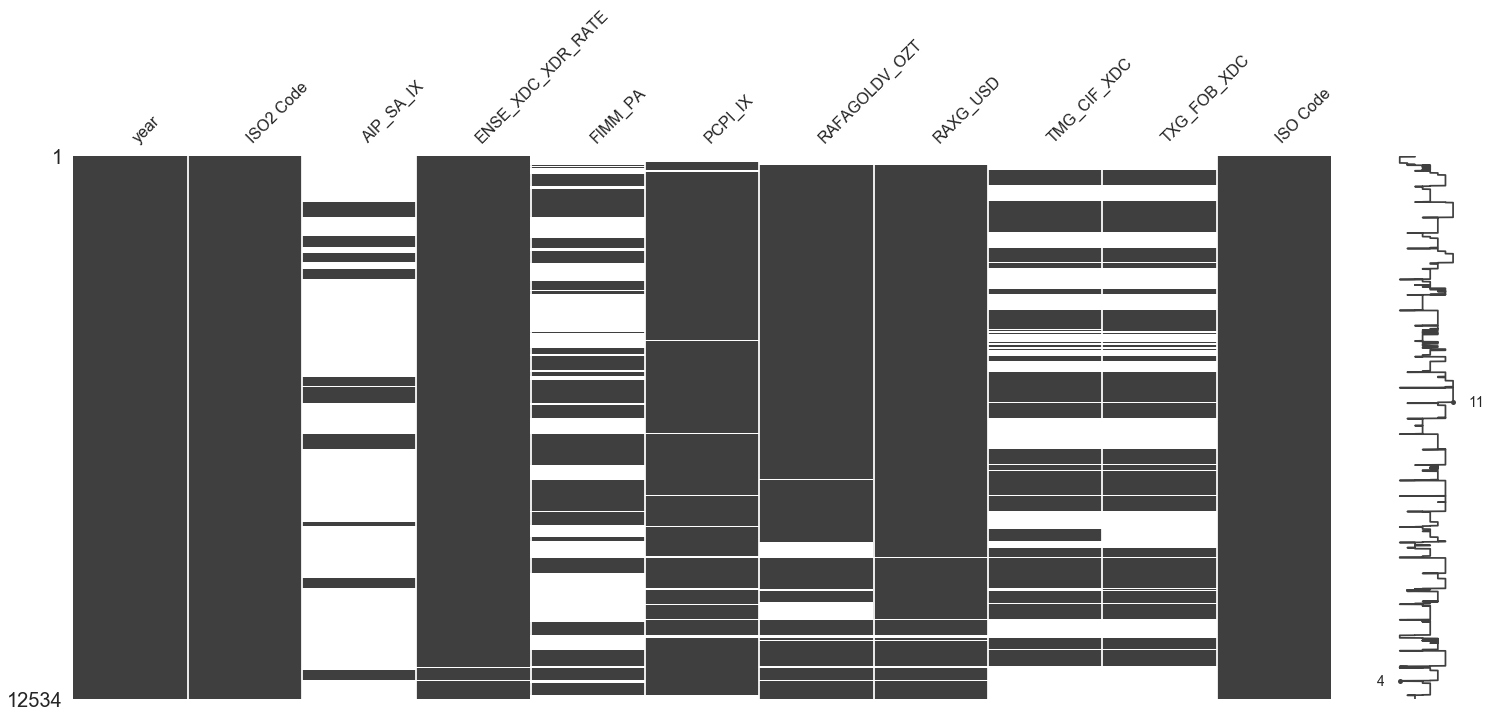

In [230]:
# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/M."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')
#Variables
variables = ".RAFAGOLDV_OZT+RAXG_USD+TXG_FOB_XDC+TMG_CIF_XDC+FIMM_PA+PCPI_IX+ENSE_XDC_XDR_RATE+AIP_SA_IX.?startPeriod=1990&endPeriod=2030"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
stack_m = pd.merge(stack, countrycodes[["ISO2 Code", "ISO Code"]], on = "ISO2 Code")
msno.matrix(stack_m)

In [231]:
#The same for price commodities index


# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/PCTOT/M."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')
#Variables
variables = ".x_gdp.?startPeriod=1990&endPeriod=2030"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.drop(["indicator"], axis = 1)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code", "@OBS_VALUE" : "PCTOT"})
#Next: Analyze the missing data and data range

stack_m2 = stack.drop_duplicates(["year", "ISO2 Code"])



In [232]:
stack_m3 = pd.merge(stack_m, stack_m2, on = ["ISO2 Code", "year"], how = "left")

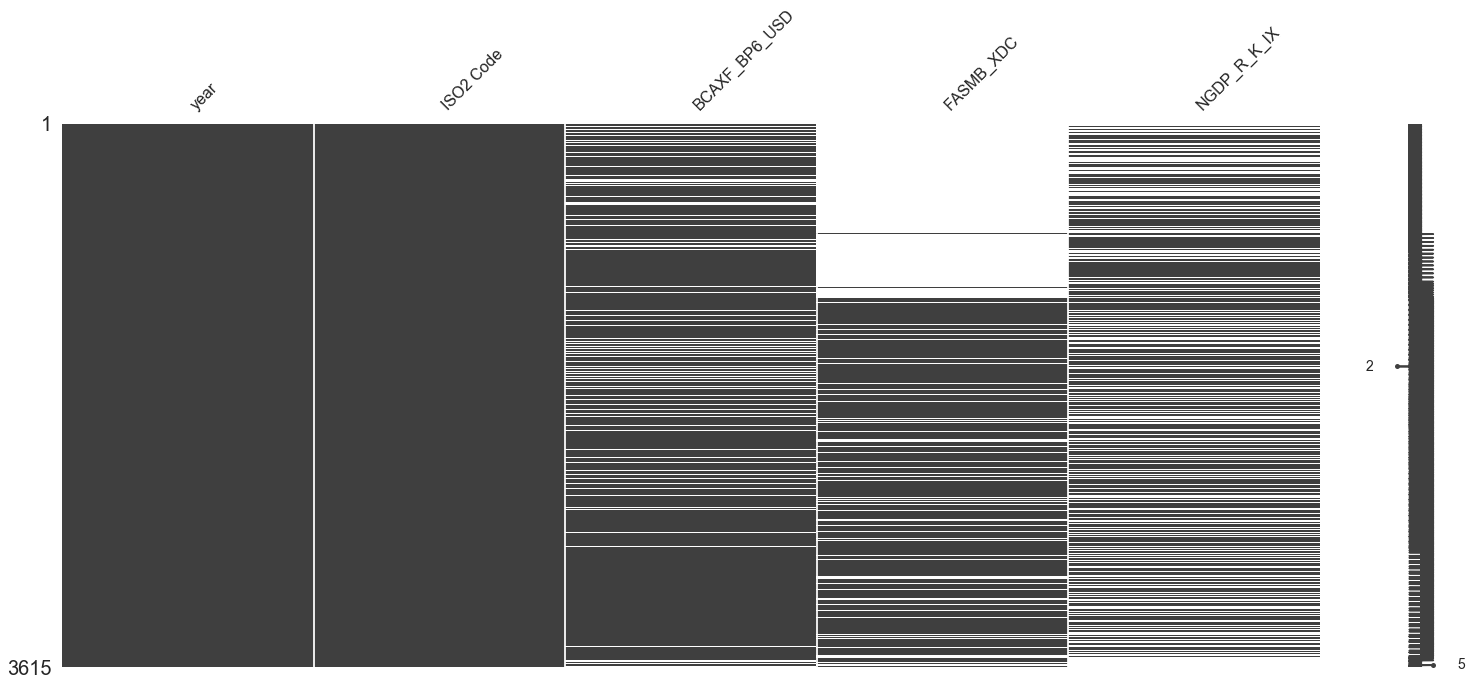

In [233]:
#Quarterly data


import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')

#Variables
variables = ".NGDP_R_K_IX+PCTOT+BCAXF_BP6_USD+FASMB_XDC.?startPeriod=1990&endPeriod=2020"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
msno.matrix(stack)
stack_q = pd.merge(stack, countrycodes[["ISO2 Code"]], on = "ISO2 Code")


In [246]:
stack_q["year"] = pd.to_datetime(stack_q["year"])
stack_m3["year"] = pd.to_datetime(stack_m3["year"])

stack = pd.merge(stack_m3, stack_q, on = ["year", "ISO2 Code"], how = "left")

In [247]:
from cif import cif

data_all, subjects_all, measures_all = cif.createDataFrameFromOECD(countries = countrycodes["ISO Code"].tolist(), frequency = 'M', subject = ["SPASTT01"])


Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/AFG.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/DZA.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BGD.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BOL.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BRA.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/BRA.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CHL.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/CHL.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/COL.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/COL.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CRI.SPAS

In [248]:
oecd = data_all.stack(level = 0)
oecd.columns = oecd.columns.droplevel(0)
oecd = oecd.reset_index()
oecd = oecd.drop(['GP', 'GY'], axis=1)  
oecd["level_0"] = pd.to_datetime(oecd["level_0"])


In [249]:
full = pd.merge(stack, oecd, left_on = ["ISO Code", "year"], right_on = ["country", "level_0"], how = "left")


In [250]:
from io import BytesIO
import pandas as pd
from urllib.request import urlopen
from zipfile import ZipFile

z = urlopen('https://www.bis.org/statistics/full_bis_total_credit_csv.zip')
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_TOTAL_CREDIT_DATAFLOW_csv_col.csv')
credit =pd.read_csv(myzip)


credit = credit[(credit["Borrowing sector"] == "Private non-financial sector") | (credit["Borrowing sector"] == "General government")]
credit = credit[(credit["Lending sector"] == "All sectors")]
credit = credit[(credit["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
credit = credit[(credit["Unit type"] == "Percentage of GDP")]
credit = credit[(credit["TC_ADJUST"] == "A")]
credit = credit[(credit["Valuation"] == "Market value")]
credit = (credit.set_index(['Borrowing sector', 'BORROWERS_CTY'])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack('Borrowing sector')
   .reset_index())
credit = credit.iloc[13:]

In [251]:
z = urlopen('https://www.bis.org/statistics/full_bis_dsr_csv.zip')
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_DSR_DATAFLOW_csv_col.csv')
debt_service =pd.read_csv(myzip)

debt_service = debt_service[(debt_service["Borrowers"] == "Private non-financial sector")]
debt_service = debt_service[(debt_service["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
debt_service = (debt_service.set_index(['BORROWERS_CTY', "Borrowers"])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack("Borrowers")
   .reset_index())

debt_service = debt_service.iloc[5:]
debt_service.columns = debt_service.columns = ["BORROWERS_CTY", "Year", "debt_service"]

In [252]:
house_prices = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HOUSECOST.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")
house_prices = house_prices[(house_prices["FREQUENCY"] == "Q")]
house_prices = house_prices[(house_prices["LOCATION"].isin(countrycodes["ISO Code"]))]
house_prices = house_prices[(house_prices["SUBJECT"] == "PRICEINCOME")]
house_prices = house_prices.drop(columns=["INDICATOR", "SUBJECT", "MEASURE", "FREQUENCY", "Flag Codes"])
house_prices.columns = house_prices.columns = ["LOCATION", "TIME", "House_prices"]

In [253]:
credit["Year"] = pd.to_datetime(credit["Year"], errors = "coerce")
debt_service["Year"] = pd.to_datetime(debt_service["Year"], errors = "coerce")
house_prices["TIME"] = pd.to_datetime(house_prices["TIME"], errors = "coerce")


full = pd.merge(full, credit, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, debt_service, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, house_prices, left_on = ["country", "year"], right_on = ["LOCATION", "TIME"], how = "left")

# 2 - Creating variables and cleaning the Data

In [254]:
full = full.drop(columns = ["country", "Year_x", "BORROWERS_CTY_x", "BORROWERS_CTY_y", "Year_y", "LOCATION", "TIME","level_0"])


In [255]:
cols = full.columns.drop(["ISO2 Code", "year"])

full[cols] = full[cols].apply(pd.to_numeric, errors='coerce')

In [256]:
iso = full["ISO2 Code"]

full = full.groupby('ISO2 Code').ffill()

full["ISO2 Code"] = iso

full["gdp_growth"] = full.groupby('ISO2 Code', sort=False).NGDP_R_K_IX.apply(
     lambda x: x.pct_change(12))

full.rename(columns={'Private non-financial sector':'credit_private', 'General government': 'credit_government'}, inplace=True)

full["credit_growth"] = full.groupby('ISO2 Code', sort=False).credit_private.apply(
     lambda x: x.pct_change(12))

full["inflation"] = full.groupby('ISO2 Code', sort=False).PCPI_IX.apply(
     lambda x: x.pct_change(12))

full["stock_growth"]  = full.groupby('ISO2 Code', sort=False).IXOB.apply(
     lambda x: x.pct_change(12))

full["house_growth"]  = full.groupby('ISO2 Code', sort=False).House_prices.apply(
     lambda x: x.pct_change(12))

full["exchange_change"] = full.groupby('ISO2 Code', sort=False).ENSE_XDC_XDR_RATE.apply(
     lambda x: x.pct_change(1))

full["industrial_growth"] = full.groupby('ISO2 Code', sort=False).AIP_SA_IX.apply(
     lambda x: x.pct_change(1))

full["commodities_growth"] = full.groupby('ISO2 Code', sort=False).PCTOT.apply(
     lambda x: x.pct_change(1))

full["reserves_gdp"] = full["RAXG_USD"]/full["NGDP_R_K_IX"]

full["imports_gdp"] = full["TMG_CIF_XDC"]/full["NGDP_R_K_IX"]

full["exports_gdp"] = full["TXG_FOB_XDC"]/full["NGDP_R_K_IX"]


In [257]:
full2 = full
g = full2.groupby('ISO2 Code')
g.count().rsub(g.size(), axis=0)

,year,AIP_SA_IX,ENSE_XDC_XDR_RATE,FIMM_PA,PCPI_IX,RAFAGOLDV_OZT,RAXG_USD,TMG_CIF_XDC,TXG_FOB_XDC,ISO Code,...,credit_growth,inflation,stock_growth,house_growth,exchange_change,industrial_growth,commodities_growth,reserves_gdp,imports_gdp,exports_gdp
ISO2 Code,,,,,,,,,,,,,,,,,,,,,
AF,0,356,0,203,170,0,0,356,356,356,...,356,182,356,356,1,356,1,356,356,356
BD,0,357,0,89,42,0,0,0,0,357,...,357,54,357,357,1,357,1,357,357,357
BO,0,357,0,60,0,0,0,357,357,357,...,357,12,357,357,1,357,1,0,357,357
BR,0,12,0,0,0,0,0,0,0,357,...,84,12,12,357,1,13,1,72,72,72
CH,0,357,0,357,0,0,0,0,0,357,...,12,12,12,12,1,357,1,0,0,0
CL,0,84,0,119,0,0,0,357,357,357,...,12,12,12,156,1,85,1,0,357,357
CO,0,120,0,62,0,0,0,0,0,357,...,93,12,24,132,1,121,1,48,48,48
CR,0,120,0,357,0,0,0,0,0,357,...,357,12,357,357,1,121,1,12,12,12
DZ,0,357,0,50,0,0,0,204,204,357,...,357,12,357,357,1,357,1,357,357,357


In [258]:
full3 = full2.drop(["ISO Code", "FASMB_XDC", "credit_government", "House_prices", "house_growth", "RAFAGOLDV_OZT", "AIP_SA_IX", "TXG_FOB_XDC", "TMG_CIF_XDC", "RAXG_USD", "PCTOT", "AIP_SA_IX"], 1 )

full3 = pd.get_dummies(full3, columns=['ISO2 Code'], prefix = ['Country'])
full3["year2"] = full3["year"].dt.strftime('%Y%m%d').astype(float)
full3 = full3.set_index("year")


In [259]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(full3)
full4 = pd.DataFrame(scaler.transform(full3), columns=full3.columns, index = full3.index)


In [260]:
#Imputing missing data with KNN

from fancyimpute import IterativeImputer, IterativeSVD, MatrixFactorization,NuclearNormMinimization, BiScaler, KNN, SoftImpute

X_filled_knn = IterativeImputer().fit_transform(full4)


In [261]:
full_fill = pd.DataFrame(data=X_filled_knn, columns=full4.columns, index = full4.index)
full2 = full2.set_index("year")
full_fill["ISO2 Code"] = full2["ISO2 Code"]
full_fill["exchange_change"] = full2["exchange_change"]

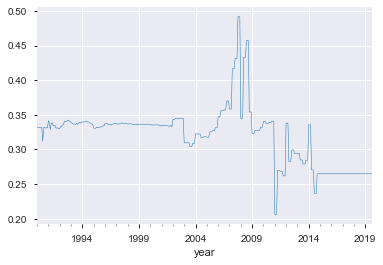

In [262]:

pt = full_fill[full_fill["Country_EG"] > 0]
pt['gdp_growth'].plot(linewidth=0.5)

In [263]:
import statsmodels.api as sm

### Creating credit gap variable

groups = full_fill.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['exchange_change']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=400000)

    g['fx_gap'] = trend
    bs = bs.append(g)

full_fill = bs

In [264]:
### Creating house price gap variable
groups = full_fill.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs2 = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['credit_private']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=400000)

    g['credit_gap'] = trend
    bs2 = bs2.append(g)

full_fill = bs2

In [290]:
import numpy as np

bs2["dummy"] = np.where(bs2['exchange_change'] <-0.05, 1, 0)
crise = bs2

crise["lag_1"] =crise.groupby("ISO2 Code")["dummy"].shift(-1)
crise["lag_2"] =crise.groupby("ISO2 Code")["dummy"].shift(-2)
crise["lag_3"] =crise.groupby("ISO2 Code")["dummy"].shift(-3)
crise["lag_4"] =crise.groupby("ISO2 Code")["dummy"].shift(-4)
crise["lag_5"] =crise.groupby("ISO2 Code")["dummy"].shift(-5)
crise["lag_6"] =crise.groupby("ISO2 Code")["dummy"].shift(-6)
crise["lag_7"] =crise.groupby("ISO2 Code")["dummy"].shift(-7)
crise["lag_8"] =crise.groupby("ISO2 Code")["dummy"].shift(-8)
crise["lag_9"] =crise.groupby("ISO2 Code")["dummy"].shift(-9)
crise["lag_10"] =crise.groupby("ISO2 Code")["dummy"].shift(-10)
crise["lag_11"] =crise.groupby("ISO2 Code")["dummy"].shift(-11)
crise["lag_12"] =crise.groupby("ISO2 Code")["dummy"].shift(-12)
crise["yt-1"] =crise.groupby("ISO2 Code")["dummy"].shift(1)

crise.fillna(0, inplace=True)

In [291]:
bs2['indicator'] = bs2["lag_1"] + bs2["lag_2"] + bs2["lag_3"] + bs2["lag_4"] + bs2["lag_5"] + bs2["lag_6"] + bs2["lag_7"] + bs2["lag_8"] + bs2["lag_9"] + bs2["lag_1"] + bs2["lag_11"] +bs2["lag_12"]
bs2['indicator2'] = np.where(bs2['indicator'] > 0, 1, 0)


#bs2['indicator'] = bs2["lag_1"] + bs2["lag_2"] + bs2["lag_3"] 
#bs2['indicator2'] = np.where(bs2['indicator'] > 0, 1, 0)

In [292]:
bs2["indicator2"].describe()

count    12534.000000
mean         0.132200
std          0.338722
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: indicator2, dtype: float64

In [293]:
### Preparing machine learning pipeline 

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

In [294]:
columns = full_fill.columns
columns = columns.drop(["ENSE_XDC_XDR_RATE", "NGDP_R_K_IX", "IXOB", "PCPI_IX", "credit_private", "year2", "dummy", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "indicator", "indicator2", "exchange_change", "fx_gap"])

# K- Fold


In [295]:
full_fill2 = full_fill.loc["1990-01-01":"2017-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2]
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = X.drop(["ISO2 Code"], axis =1)

In [296]:
X

,FIMM_PA,BCAXF_BP6_USD,debt_service,gdp_growth,credit_growth,inflation,stock_growth,industrial_growth,commodities_growth,reserves_gdp,...,Country_SD,Country_TH,Country_TR,Country_TZ,Country_UA,Country_UG,Country_UY,Country_UZ,Country_VN,Country_ZA
year,,,,,,,,,,,,,,,,,,,,,
1990-01-01,0.000412,0.369996,0.696350,0.262775,0.444940,0.004360,0.003253,0.452932,0.378943,0.020044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-02-01,0.000430,0.369902,0.654431,0.270130,0.449520,0.004454,0.003514,0.452923,0.378587,0.030404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-03-01,0.000431,0.369948,0.653753,0.270251,0.449514,0.004454,0.003517,0.452922,0.378965,0.030497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-04-01,0.000430,0.369952,0.655349,0.269930,0.449405,0.004453,0.003508,0.452920,0.378984,0.030346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-05-01,0.000429,0.369969,0.656053,0.269776,0.449340,0.004453,0.003503,0.452919,0.379124,0.030292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,0.000051,0.339117,0.156757,0.264866,0.423975,0.001792,0.000300,0.448992,0.390113,0.059403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-09-01,0.000051,0.339117,0.156757,0.264866,0.423975,0.001821,0.000304,0.448980,0.379672,0.063027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-10-01,0.000051,0.365111,0.154054,0.264866,0.423133,0.001799,0.000325,0.448979,0.376313,0.062421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [297]:
### train test split

X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=full_fill2['indicator2'])

In [298]:
# Spot-Check Algorithms
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    basedModels.append(('XGB'   , XGBClassifier()))


    
    return basedModels

In [299]:
from sklearn.metrics import confusion_matrix


def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'roc_auc'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state= 1990)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [300]:
from plotly import graph_objs as go
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [301]:
from plotly import graph_objs as go

In [302]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.767128 (0.013663)
LDA: 0.774244 (0.014150)
KNN: 0.940754 (0.012824)
CART: 0.843298 (0.017994)
NB: 0.755465 (0.012974)
SVM: 0.770396 (0.017148)
AB: 0.837225 (0.012896)
GBM: 0.898413 (0.014914)
RF: 0.960669 (0.008826)
ET: 0.969387 (0.005601)
XGB: 0.893601 (0.013399)


In [ ]:
model =  ExtraTreesClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(y_test, y_pred)



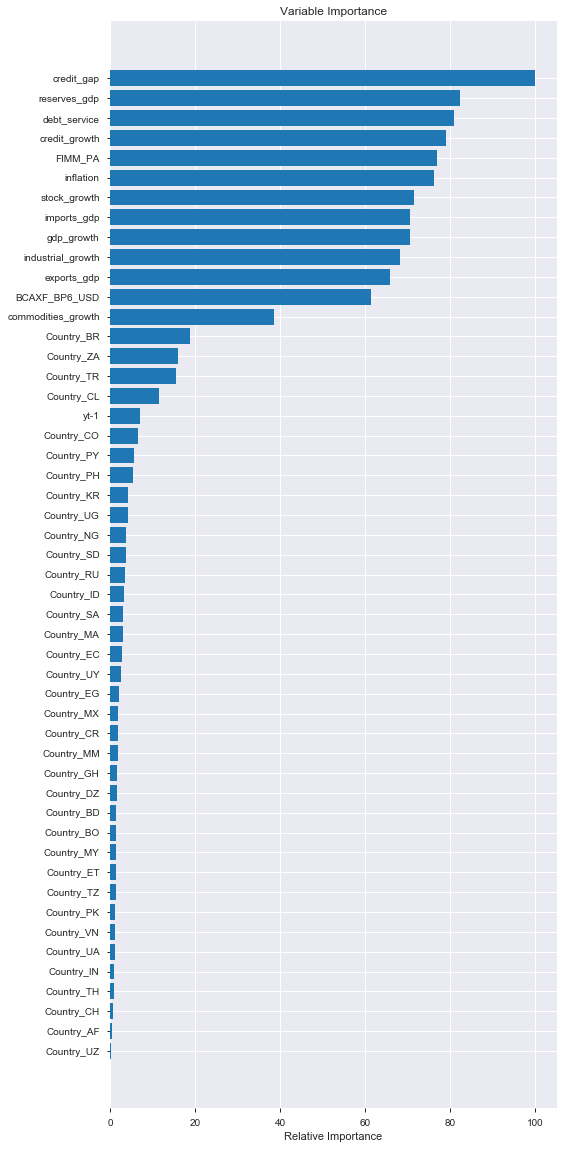

<Figure size 7200x10800 with 0 Axes>

In [304]:
### feature importance

clf = ExtraTreesClassifier(random_state= 1984)

clf.fit(X_train, y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(100,150))
plt.show()

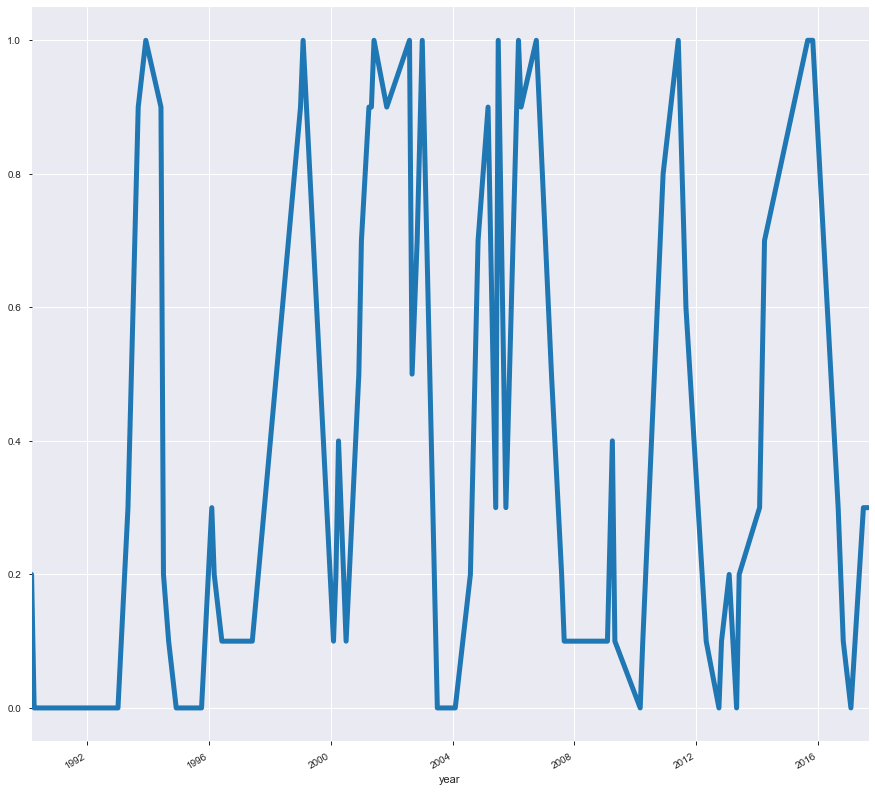

In [305]:
X_test["pred"] = y_prob
X_test2 = X_test[X_test["Country_BR"] > 0]
X_test2['pred'].plot(linewidth=5, figsize=(15,15))


# Time-Test

In [306]:
full_fill2 = full_fill.loc["1990-01-01":"2017-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2]
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)

X = X.drop(["ISO2 Code"], axis =1)

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2017-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2017-12-31"]



In [307]:

model =  XGBClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(Y_test, y_pred)

array([[2943,   26],
       [ 438,   13]], dtype=int64)

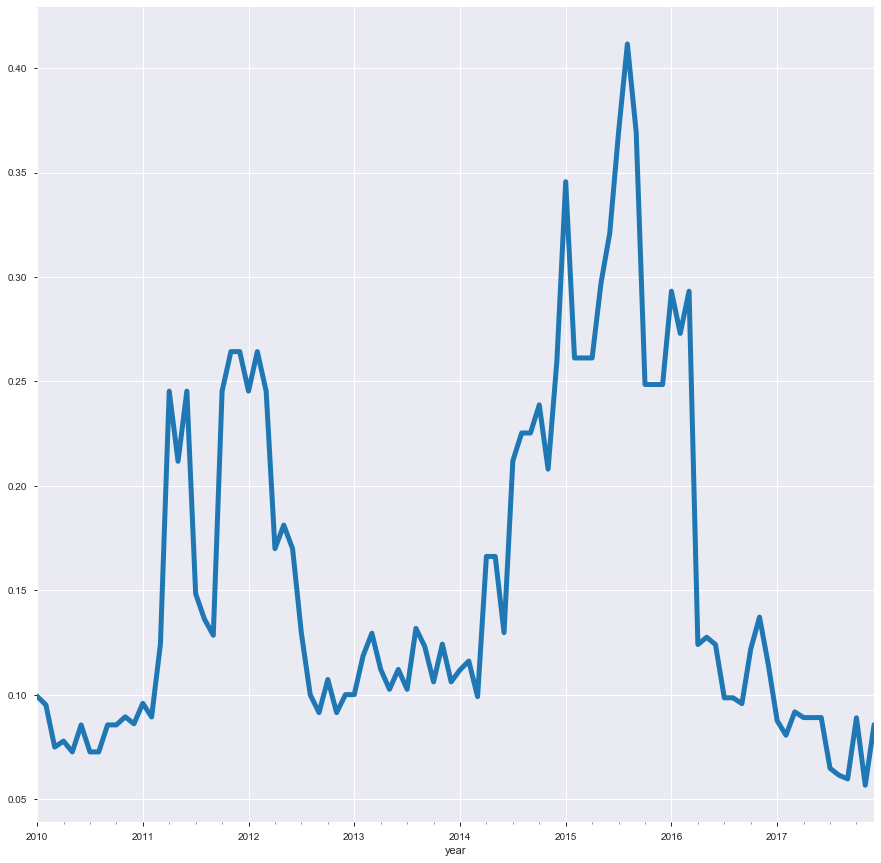

In [308]:
X_test["pred"] = y_prob
X_test2 = X_test[X_test["Country_BR"] > 0]
X_test2['pred'].plot(linewidth=5, figsize=(15,15))


# Time-Test (variables in differences)

In [309]:
full_fill2 = full_fill.loc["1990-01-01":"2017-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2].groupby("ISO2 Code").diff()
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)

X = X.fillna(X.mean())
X = X.fillna(0)

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2017-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2017-12-31"]

In [310]:
model =   XGBClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(Y_test, y_pred)

array([[2933,   36],
       [ 432,   19]], dtype=int64)

In [311]:
models = GetBasedModel()
names,results = BasedLine2(X_train, Y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.340633 (0.193938)
LDA: 0.364685 (0.160707)
KNN: 0.415596 (0.163273)
CART: 0.459332 (0.133689)
NB: 0.318908 (0.124727)
SVM: 0.364520 (0.210655)
AB: 0.357727 (0.123052)
GBM: 0.399605 (0.180461)
RF: 0.459608 (0.179440)
ET: 0.403987 (0.163628)
XGB: 0.371777 (0.179649)


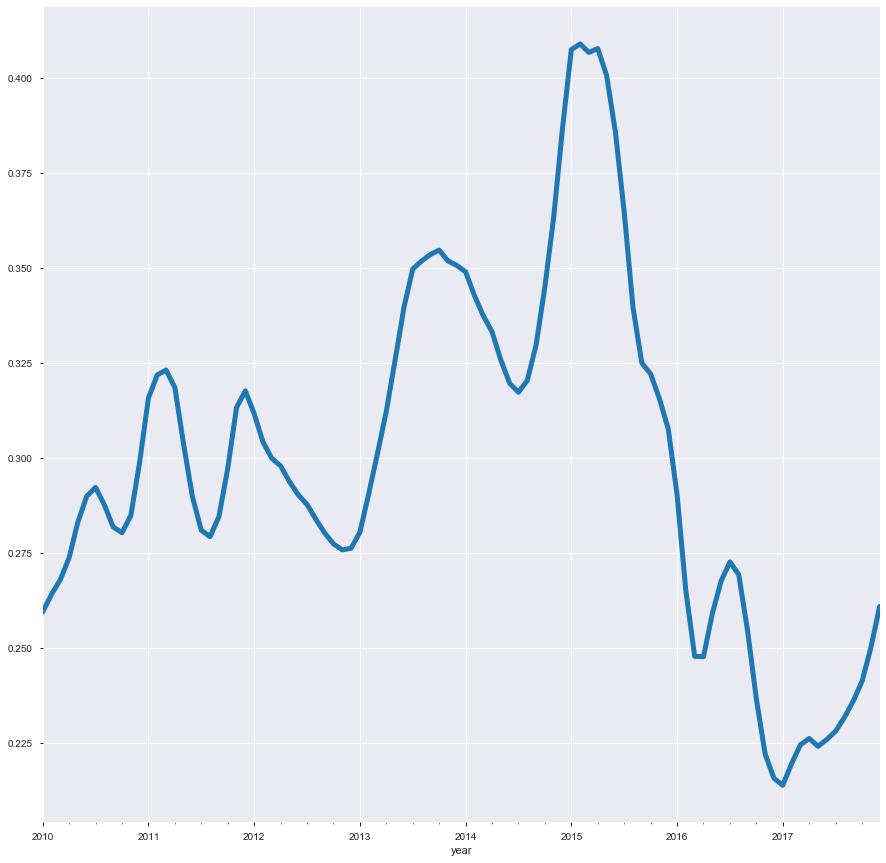

In [323]:
X_test["pred"] = y_prob
X_test2 = X_test[X_test["Country_BR"] > 0]
cycle, trend = sm.tsa.filters.hpfilter(X_test2["pred"], lamb=5)
X_test2["hp"] = trend
X_test2['hp'].plot(linewidth=5, figsize=(15,15))


In [ ]:
X_test2["pred"].rolling(window=12).mean()